In [267]:
# Imports

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score,RepeatedStratifiedKFold, KFold
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import optuna

# models
import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# **Loading the data**

In [150]:
train_set = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
train_set['Transported'] = train_set['Transported'].astype(int)
train_set.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1


In [151]:
test_set = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
test_set.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [152]:
df = pd.concat([train_set, test_set], axis=0)
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,NaN
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,NaN
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,NaN
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN


# **EDA**

In [153]:
# Columns in the set :

df.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

In [154]:
df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
count,12700.000000,12707.000000,12681.000000,12664.000000,12686.000000,12702.000000,8693.000000
mean,28.771969,222.897852,451.961675,174.906033,308.476904,306.789482,0.503624
std,14.387261,647.596664,1584.370747,590.558690,1130.279641,1180.097223,0.500016
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,38.000000,49.000000,77.000000,29.000000,57.000000,42.000000,1.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,1.000000


In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12970 entries, 0 to 4276
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   float64
dtypes: float64(7), object(7)
memory usage: 1.5+ MB


As we can see there are missing values.

In [156]:
df.isnull().sum().sort_values(ascending=False)

Transported     4277
CryoSleep        310
ShoppingMall     306
Cabin            299
VIP              296
Name             294
FoodCourt        289
HomePlanet       288
Spa              284
Destination      274
Age              270
VRDeck           268
RoomService      263
PassengerId        0
dtype: int64

There are some missing values.

<Axes: xlabel='Transported'>

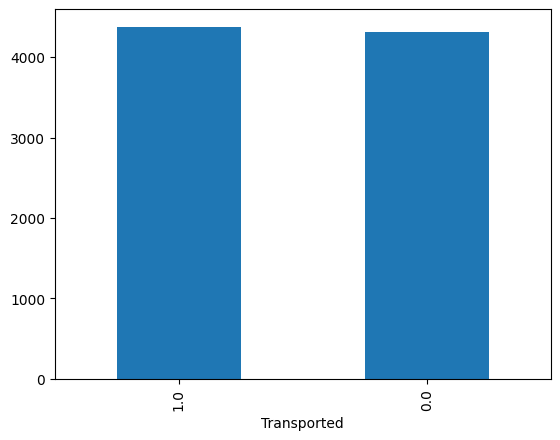

In [157]:
# Plot the number of passengers that have been transported

plot_df = df.Transported.value_counts()
plot_df.plot(kind='bar')

The classes are equilibrated.

# **Feature Engineering**

**Passenger Group**

We create a new feature indicating the group in which a passenger is, as well as its size.

In [158]:
group = df['PassengerId'].apply(lambda x: x.split('_')[0]).value_counts().to_dict()
df['Group_size'] = df['PassengerId'].apply(lambda x: group[x.split('_')[0]])
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group_size
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0.0,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1.0,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0.0,2
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0.0,2
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,NaN,2
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,NaN,1
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,NaN,1
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN,1


In [159]:
# Set the passenger ID as index

df.set_index('PassengerId', inplace=True)
df

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group_size
PassengerId,,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0.0,1
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1.0,1
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0.0,2
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0.0,2
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,NaN,2
9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,NaN,1
9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,NaN,1


**Home planet**

There are a few missing values for HomePlanet. We are going to fill out the missing values in a way that preserves the distribution.

In [160]:
tmp = df['HomePlanet'].value_counts()
tmp

HomePlanet
Earth     6865
Europa    3133
Mars      2684
Name: count, dtype: int64

In [161]:
l_planet = tmp.index

n_planet = tmp.values
probs = n_planet/sum(n_planet)
probs

array([0.5413184 , 0.24704305, 0.21163854])

In [162]:
df.loc[df['HomePlanet'].isna(), 'HomePlanet'] = np.random.choice(l_planet, df['HomePlanet'].isna().sum(), p=probs)
df['HomePlanet'].isnull().sum()

0

**CryoSleep**

We replace null values with False.

In [163]:
df['CryoSleep'].fillna(df['CryoSleep'].median(), inplace=True)
df['CryoSleep'] = df['CryoSleep'].astype(int)
df['CryoSleep']

PassengerId
0001_01    0
0002_01    0
0003_01    0
0003_02    0
0004_01    0
          ..
9266_02    1
9269_01    0
9271_01    1
9273_01    0
9277_01    1
Name: CryoSleep, Length: 12970, dtype: int64

**Cabin**

We split the 'Cabin' variable in 3.

In [164]:
df[["Deck", "Cabin_num", "Side"]] = df["Cabin"].str.split("/", expand=True)
df = df.drop('Cabin', axis=1)
df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group_size,Deck,Cabin_num,Side
PassengerId,,,,,,,,,,,,,,,,
0001_01,Europa,0,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0.0,1,B,0,P
0002_01,Earth,0,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1.0,1,F,0,S
0003_01,Europa,0,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0.0,2,A,0,S
0003_02,Europa,0,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0.0,2,A,0,S
0004_01,Earth,0,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1.0,1,F,1,S


**Deck**

We are going to fill the missing values with one of the two most popular decks randomly.

In [165]:
df['Deck'].value_counts()

Deck
F    4239
G    3781
E    1323
B    1141
C    1102
D     720
A     354
T      11
Name: count, dtype: int64

In [166]:
df.loc[df['Deck']=='-1', 'Deck'] = np.random.choice(['F', 'G'], sum(df['Deck']=='-1'), p=[0.5, 0.5])

In [167]:
df['Deck'].value_counts()

Deck
F    4239
G    3781
E    1323
B    1141
C    1102
D     720
A     354
T      11
Name: count, dtype: int64

**Cabin_num**

For Cabin_num, we input the mean value (there is a rich variety of values)

In [168]:
df['Cabin_num'].nunique()

1894

In [169]:
df['Cabin_num'], _ = df['Cabin_num'].factorize()
df['Cabin_num']

PassengerId
0001_01       0
0002_01       0
0003_01       0
0003_02       0
0004_01       1
           ... 
9266_02    1529
9269_01      -1
9271_01     361
9273_01     287
9277_01    1811
Name: Cabin_num, Length: 12970, dtype: int64

In [170]:
df['Cabin_num'].fillna(int(df['Cabin_num'].mean()), inplace=True)

<Axes: xlabel='Cabin_num', ylabel='Count'>

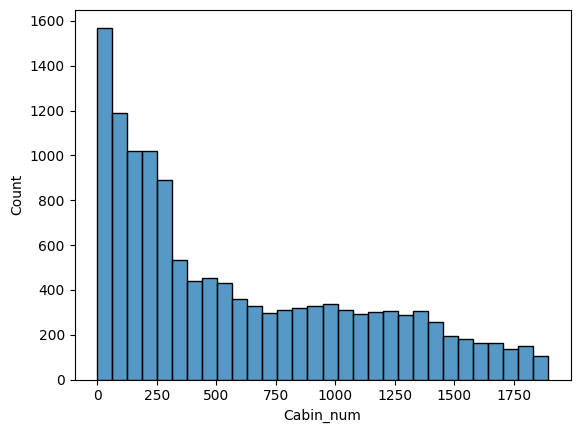

In [172]:
sns.histplot(df['Cabin_num'], bins=30, kde=False)

**Side**

For the Side, we fill in the missing values by a random value.

In [173]:
df.loc[df['Side']=='-1', 'Side'] = np.random.choice(['S', 'P'], sum(df['Side']=='-1'), 
                                                              p=[0.5, 0.5])

In [174]:
df['Side'] = df['Side'].map({'S':0, 'P':1})
df['Side'].value_counts()

Side
0.0    6381
1.0    6290
Name: count, dtype: int64

**Destination**

We assign a random planet for the missing values so that the distribution is preserved.

In [175]:
tmp = df['Destination'].value_counts()
tmp

Destination
TRAPPIST-1e      8871
55 Cancri e      2641
PSO J318.5-22    1184
Name: count, dtype: int64

In [176]:
l_destination = tmp.index

n_destination = tmp.values

probs = n_destination/sum(n_destination)
probs

array([0.69872401, 0.20801827, 0.09325772])

In [177]:
df.loc[df['Destination'].isna(), 'Destination'] = np.random.choice(l_planet, df['Destination'].isna().sum(), p=probs)
df['Destination'].isnull().sum()

0

**Age**

We fill the missing values with random values taken uniformly around the mean age (plus or minus the std)

In [178]:
mean_age = df["Age"].mean()
std_age = df["Age"].std()
is_null = df["Age"].isnull().sum()
rand_sample = np.random.uniform(mean_age - std_age, mean_age + std_age, size = is_null)
df.loc[df['Age'].isna(), 'Age'] = rand_sample

<Axes: xlabel='Age', ylabel='Count'>

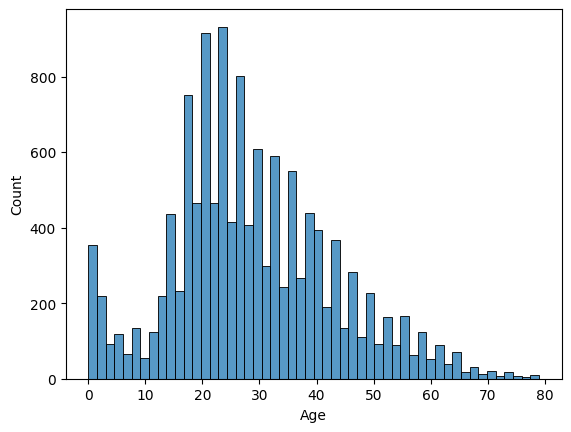

In [179]:
sns.histplot(df['Age'])

**VIP**

We fill the missing values with False.

In [180]:
df['VIP'].fillna(False, inplace=True)
df['VIP'] = df['VIP'].astype(int)

**RoomService, FoodCourt, ShoppingMall, Spa, VRDeck**

We have decided to create a new feature—'total_spending'—which combines all the spending across these amenities. This gives us a holistic view of a passenger's total expenditure on board.

As the data in these features is highly skewed, we will fill the missing values with the median values for each column. This strategy is more robust to outliers and skewed data than filling with the mean.

Speaking of outliers, we noticed that these features contain several extreme values. To deal with them, we will transform these features to a log scale, and to 0 will be assigned 0.356.

In [181]:
cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for col in cols:
    df[col].fillna(df[col].median(), inplace=True)

In [182]:
df['total_spending'] = df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck']

In [183]:
cols.append('total_spending')

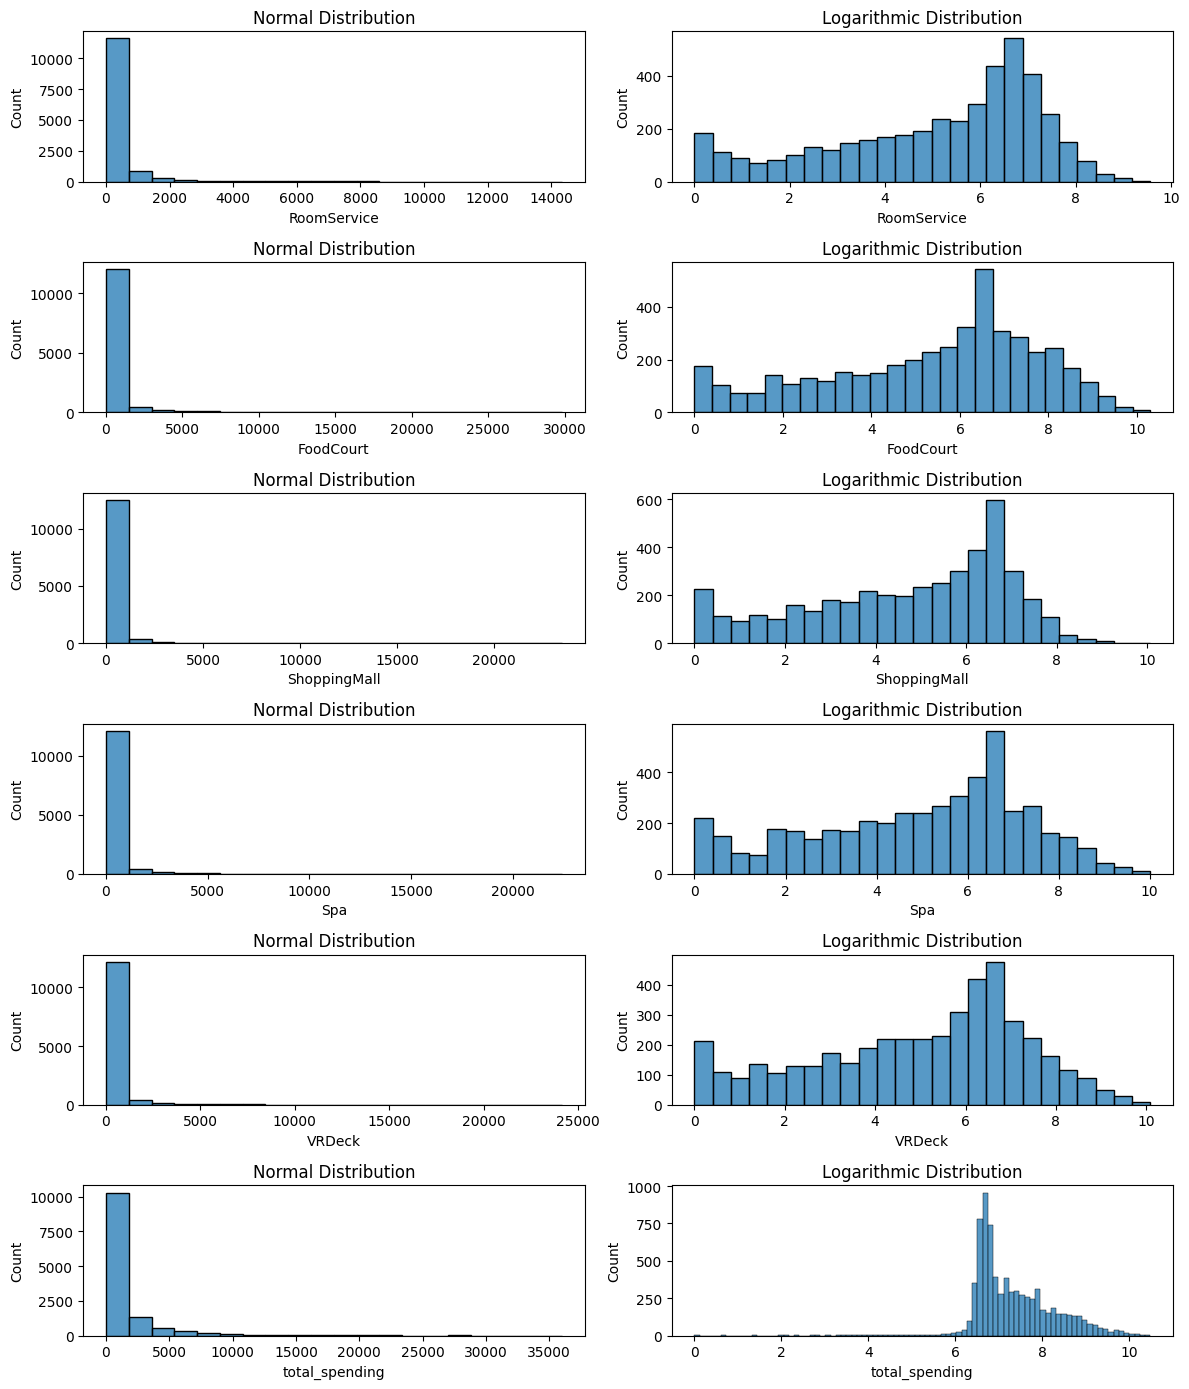

In [184]:
fig, axes = plt.subplots(len(cols),2, figsize=(12,14))
for i, col in enumerate(cols):
    sns.histplot(data=df, x=col, ax=axes[i, 0], bins=20)
    sns.histplot(data=np.log(df[[col]]), x=col, ax=axes[i, 1])
    axes[i, 0].set_title('Normal Distribution')
    axes[i, 1].set_title('Logarithmic Distribution')
plt.tight_layout()

In [185]:
for col in cols:
    df.loc[df[col]==0, col] = 0.367
    df[col] = np.log(df[col])

**Name**

We are going to encode the names, filling the missing values with a dummy name.

In [186]:
df['Name'] = df['Name'].fillna('Skibidi Toilet')
df['Name']

PassengerId
0001_01      Maham Ofracculy
0002_01         Juanna Vines
0003_01        Altark Susent
0003_02         Solam Susent
0004_01    Willy Santantines
                 ...        
9266_02          Jeron Peter
9269_01        Matty Scheron
9271_01          Jayrin Pore
9273_01       Kitakan Conale
9277_01     Lilace Leonzaley
Name: Name, Length: 12970, dtype: object

In [187]:
name_parts = df['Name'].apply(lambda x: x.split(' '))
df['FirstName'] = name_parts.apply(lambda x: x[0])
df['LastName'] = name_parts.apply(lambda x: x[-1])
df[['FirstName', 'LastName']]

,FirstName,LastName
PassengerId,,
0001_01,Maham,Ofracculy
0002_01,Juanna,Vines
0003_01,Altark,Susent
0003_02,Solam,Susent
0004_01,Willy,Santantines
...,...,...
9266_02,Jeron,Peter
9269_01,Matty,Scheron
9271_01,Jayrin,Pore


In [188]:
label_encoder = LabelEncoder()
df["FirstName"] = label_encoder.fit_transform(df.loc[:, "FirstName"])

label_encoder = LabelEncoder()
df["LastName"] = label_encoder.fit_transform(df.loc[:, "LastName"])
df

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group_size,Deck,Cabin_num,Side,total_spending,FirstName,LastName
PassengerId,,,,,,,,,,,,,,,,,,,
0001_01,Europa,0,TRAPPIST-1e,39.000000,0,-1.002393,-1.002393,-1.002393,-1.002393,-1.002393,Maham Ofracculy,0.0,1,B,0,1.0,-1.002393,1708,1551
0002_01,Earth,0,TRAPPIST-1e,24.000000,0,4.691348,2.197225,3.218876,6.308098,3.784190,Juanna Vines,1.0,1,F,0,0.0,6.601230,1493,2290
0003_01,Europa,0,TRAPPIST-1e,58.000000,1,3.761200,8.182000,-1.002393,8.812099,3.891820,Altark Susent,0.0,2,A,0,0.0,9.247925,170,2153
0003_02,Europa,0,TRAPPIST-1e,33.000000,0,-1.002393,7.156956,5.916202,8.110427,5.262690,Solam Susent,0.0,2,A,0,0.0,8.551788,2425,2153
0004_01,Earth,0,TRAPPIST-1e,16.000000,0,5.713733,4.248495,5.017280,6.336826,0.693147,Willy Santantines,1.0,1,F,1,0.0,6.994850,2816,1924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9266_02,Earth,1,TRAPPIST-1e,34.000000,0,-1.002393,-1.002393,-1.002393,-1.002393,-1.002393,Jeron Peter,NaN,2,G,1529,0.0,-1.002393,1445,1657
9269_01,Earth,0,TRAPPIST-1e,42.000000,0,-1.002393,6.741701,2.833213,2.302585,4.969813,Matty Scheron,NaN,1,NaN,-1,NaN,6.925595,1766,1937
9271_01,Mars,1,55 Cancri e,22.694126,0,-1.002393,-1.002393,-1.002393,-1.002393,-1.002393,Jayrin Pore,NaN,1,D,361,1.0,-1.002393,1429,1707


In [189]:
df.drop(columns="Name", inplace=True)

In [190]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12970 entries, 0001_01 to 9277_01
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   HomePlanet      12970 non-null  object 
 1   CryoSleep       12970 non-null  int64  
 2   Destination     12970 non-null  object 
 3   Age             12970 non-null  float64
 4   VIP             12970 non-null  int64  
 5   RoomService     12970 non-null  float64
 6   FoodCourt       12970 non-null  float64
 7   ShoppingMall    12970 non-null  float64
 8   Spa             12970 non-null  float64
 9   VRDeck          12970 non-null  float64
 10  Transported     8693 non-null   float64
 11  Group_size      12970 non-null  int64  
 12  Deck            12671 non-null  object 
 13  Cabin_num       12970 non-null  int64  
 14  Side            12671 non-null  float64
 15  total_spending  12970 non-null  float64
 16  FirstName       12970 non-null  int64  
 17  LastName        12970 non-nu

In [191]:
df.describe()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group_size,Cabin_num,Side,total_spending,FirstName,LastName
count,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,8693.000000,12970.000000,12970.000000,12671.000000,12970.000000,12970.000000,12970.000000
mean,0.353200,28.778103,0.021049,1.059445,1.228764,0.915650,1.171545,1.056254,0.503624,2.022976,594.203855,0.496409,3.825525,1453.215806,1217.623053
std,0.477983,14.282412,0.143552,3.152490,3.361060,2.996853,3.193439,3.164128,0.500016,1.577102,519.740311,0.500007,4.174875,815.622982,702.168059
min,0.000000,0.000000,0.000000,-1.002393,-1.002393,-1.002393,-1.002393,-1.002393,0.000000,1.000000,-1.000000,0.000000,-1.002393,0.000000,0.000000
25%,0.000000,19.000000,0.000000,-1.002393,-1.002393,-1.002393,-1.002393,-1.002393,0.000000,1.000000,156.000000,0.000000,-1.002393,770.000000,607.000000
50%,0.000000,27.000000,0.000000,-1.002393,-1.002393,-1.002393,-1.002393,-1.002393,1.000000,1.000000,415.000000,0.000000,6.573680,1458.000000,1223.000000
75%,1.000000,37.000000,0.000000,3.755317,4.139135,3.135494,3.912023,3.583519,1.000000,2.000000,991.750000,1.000000,7.273786,2177.000000,1823.750000
max,1.000000,79.000000,1.000000,9.569901,10.302700,10.064415,10.017173,10.091335,1.000000,8.000000,1893.000000,1.000000,10.490913,2883.000000,2406.000000


**Categorical Features**

For the categorical features we are going to use one-hot encoding

In [192]:
categorical_features = ['HomePlanet', 'Destination', 'Deck']
df = pd.concat([df, pd.get_dummies(df[categorical_features])], axis=1)
df.drop(columns=categorical_features, inplace=True)
df

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group_size,...,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T
PassengerId,,,,,,,,,,,,,,,,,,,,,
0001_01,0,39.000000,0,-1.002393,-1.002393,-1.002393,-1.002393,-1.002393,0.0,1,...,False,True,False,True,False,False,False,False,False,False
0002_01,0,24.000000,0,4.691348,2.197225,3.218876,6.308098,3.784190,1.0,1,...,False,True,False,False,False,False,False,True,False,False
0003_01,0,58.000000,1,3.761200,8.182000,-1.002393,8.812099,3.891820,0.0,2,...,False,True,True,False,False,False,False,False,False,False
0003_02,0,33.000000,0,-1.002393,7.156956,5.916202,8.110427,5.262690,0.0,2,...,False,True,True,False,False,False,False,False,False,False
0004_01,0,16.000000,0,5.713733,4.248495,5.017280,6.336826,0.693147,1.0,1,...,False,True,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9266_02,1,34.000000,0,-1.002393,-1.002393,-1.002393,-1.002393,-1.002393,NaN,2,...,False,True,False,False,False,False,False,False,True,False
9269_01,0,42.000000,0,-1.002393,6.741701,2.833213,2.302585,4.969813,NaN,1,...,False,True,False,False,False,False,False,False,False,False
9271_01,1,22.694126,0,-1.002393,-1.002393,-1.002393,-1.002393,-1.002393,NaN,1,...,False,False,False,False,False,True,False,False,False,False


In [193]:
test_df  = df[train_set.shape[0]:]
train_df = df[:train_set.shape[0]]
test_df

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group_size,...,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T
PassengerId,,,,,,,,,,,,,,,,,,,,,
0013_01,1,27.000000,0,-1.002393,-1.002393,-1.002393,-1.002393,-1.002393,NaN,1,...,False,True,False,False,False,False,False,False,True,False
0018_01,0,19.000000,0,-1.002393,2.197225,-1.002393,7.945555,-1.002393,NaN,1,...,False,True,False,False,False,False,False,True,False,False
0019_01,1,31.000000,0,-1.002393,-1.002393,-1.002393,-1.002393,-1.002393,NaN,1,...,False,False,False,False,True,False,False,False,False,False
0021_01,0,38.000000,0,-1.002393,8.802673,-1.002393,5.198497,6.371612,NaN,1,...,False,True,False,False,True,False,False,False,False,False
0023_01,0,20.000000,0,2.302585,-1.002393,6.453625,-1.002393,-1.002393,NaN,1,...,False,True,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9266_02,1,34.000000,0,-1.002393,-1.002393,-1.002393,-1.002393,-1.002393,NaN,2,...,False,True,False,False,False,False,False,False,True,False
9269_01,0,42.000000,0,-1.002393,6.741701,2.833213,2.302585,4.969813,NaN,1,...,False,True,False,False,False,False,False,False,False,False
9271_01,1,22.694126,0,-1.002393,-1.002393,-1.002393,-1.002393,-1.002393,NaN,1,...,False,False,False,False,False,True,False,False,False,False


In [194]:
corr = train_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group_size,Cabin_num,Side,total_spending,FirstName,LastName,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_Earth,Destination_Europa,Destination_Mars,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T
CryoSleep,1.000000,-0.070536,-0.078281,-0.477623,-0.487526,-0.467691,-0.499310,-0.480633,0.460132,0.079363,-0.034214,-0.020889,-0.848178,-0.004885,0.009379,-0.106717,0.093038,0.031600,0.065589,-0.029733,-0.004665,0.002862,0.087764,-0.103213,-0.030594,0.124049,0.028433,-0.066678,-0.110644,-0.220150,0.241399,-0.017579
Age,-0.070536,1.000000,0.091310,0.118314,0.195974,0.096352,0.183329,0.164897,-0.072980,-0.176422,-0.129365,-0.011177,0.242264,-0.013215,0.003157,-0.197136,0.212681,0.014702,0.017595,0.009761,0.007133,0.003538,-0.028577,-0.001485,0.074841,0.104359,0.125312,0.075488,0.030378,-0.019002,-0.210241,0.013622
VIP,-0.078281,0.091310,1.000000,0.050014,0.121260,0.031585,0.088057,0.100704,-0.037261,0.002856,-0.097200,0.010163,0.111169,0.000108,-0.004763,-0.160041,0.145299,0.041215,0.045167,-0.005566,-0.010917,-0.005924,-0.000592,-0.035309,0.132574,0.065080,0.065591,0.067678,-0.012912,-0.057578,-0.098863,-0.003672
RoomService,-0.477623,0.118314,0.050014,1.000000,0.109856,0.379814,0.168508,0.112487,-0.357962,-0.124401,0.054755,0.022428,0.544593,0.025670,-0.019395,-0.047306,-0.201532,0.273791,-0.071909,0.016663,-0.000149,-0.024277,-0.053960,0.093641,-0.047057,-0.144986,-0.094562,0.162345,0.093174,0.226568,-0.208282,0.007954
FoodCourt,-0.487526,0.195974,0.121260,0.109856,1.000000,0.118986,0.434035,0.468078,-0.147283,-0.043766,-0.137886,-0.011084,0.621075,-0.029107,-0.001845,-0.093511,0.306056,-0.212571,0.075180,-0.004141,0.000808,0.012828,-0.068068,-0.023356,0.144882,0.087379,0.201285,0.032835,0.013880,-0.029691,-0.227179,0.037679
ShoppingMall,-0.467691,0.096352,0.031585,0.379814,0.118986,1.000000,0.179120,0.118930,-0.190588,-0.120851,0.070277,0.016935,0.528238,0.012665,-0.004869,0.010216,-0.184452,0.184819,-0.078527,0.010749,0.009142,-0.015864,-0.027005,0.082118,-0.052177,-0.118657,-0.086380,0.103044,0.095927,0.215197,-0.181224,-0.012591
Spa,-0.499310,0.183329,0.088057,0.168508,0.434035,0.179120,1.000000,0.389960,-0.363295,-0.066622,-0.094422,-0.002859,0.619800,-0.013575,-0.001677,-0.079164,0.192065,-0.108227,0.027304,0.014842,-0.008267,0.005594,-0.070697,0.017006,0.106876,0.028597,0.127033,0.058311,0.036691,0.023401,-0.213983,0.030320
VRDeck,-0.480633,0.164897,0.100704,0.112487,0.468078,0.118930,0.389960,1.000000,-0.340890,-0.059139,-0.099573,0.011188,0.599973,-0.015596,0.010727,-0.035488,0.226716,-0.198985,0.048860,0.017409,-0.011017,0.000983,-0.048137,-0.015534,0.107961,0.052986,0.161173,0.019760,0.020065,0.008928,-0.204389,0.031920
Transported,0.460132,-0.072980,-0.037261,-0.357962,-0.147283,-0.190588,-0.363295,-0.340890,1.000000,0.082644,-0.042243,-0.103775,-0.471257,-0.009132,0.014468,-0.168548,0.176103,0.018707,0.108722,-0.013437,0.018936,0.008651,0.000092,-0.094700,-0.002623,0.144733,0.108193,-0.034046,-0.097965,-0.087753,0.016269,-0.014568
Group_size,0.079363,-0.176422,0.002856,-0.124401,-0.043766,-0.120851,-0.066622,-0.059139,0.082644,1.000000,-0.052577,-0.014983,-0.164123,-0.010129,0.002553,-0.095335,0.129279,-0.021167,0.059228,-0.007532,-0.008697,0.023383,-0.057293,-0.014721,0.038748,0.079807,0.104512,-0.005688,-0.064911,-0.124731,0.039220,-0.015563


In [294]:
# Split the dataset into training and validation sets :

X_train, X_valid, y_train, y_valid = train_test_split(train_df.drop('Transported', axis=1), train_df[['Transported']], 
                                                    test_size=0.15, random_state=42)
X_train

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group_size,Cabin_num,...,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T
PassengerId,,,,,,,,,,,,,,,,,,,,,
5070_01,0,20.0,0,6.295266,5.164786,-1.002393,1.609438,-1.002393,1,922,...,False,False,False,False,False,False,False,True,False,False
5028_01,0,47.0,0,7.551712,2.890372,-1.002393,4.488636,8.391857,1,56,...,False,False,True,False,False,False,False,False,False,False
8656_02,0,38.0,1,-1.002393,7.168580,-1.002393,7.518064,7.344073,3,95,...,False,False,True,False,False,False,False,False,False,False
8232_01,0,19.0,0,1.609438,6.501290,-1.002393,4.812184,6.086775,1,1488,...,False,True,False,False,False,False,False,True,False,False
6906_03,1,7.0,0,-1.002393,-1.002393,-1.002393,-1.002393,-1.002393,3,1357,...,False,True,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6076_01,0,18.0,0,2.639057,0.693147,4.969813,6.413459,-1.002393,1,1008,...,False,True,False,False,False,False,False,False,True,False
5537_01,0,50.0,0,6.536692,-1.002393,3.401197,6.635947,6.059123,1,1017,...,False,True,False,False,False,False,False,True,False,False
5756_06,0,22.0,0,5.062595,-1.002393,6.165418,-1.002393,3.258097,8,1131,...,True,False,False,False,False,False,False,True,False,False


# **Model**

We compare XGBoost, CatBoost and LightGB to see which one is the best for our problem

In [265]:
clf_xgb = XGBClassifier('binary:logistic',
    colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=10, 
                             min_child_weight=1.7817, n_estimators=1500,
                             reg_alpha=4.5, reg_lambda=8.5,
                             subsample=0.5213,
                             random_state=42)
clf_lgb = lgb.LGBMClassifier()
clf_cat = CatBoostClassifier(verbose=False)

In [ ]:
# Cross-validation on training set :

cv_xgb = cross_val_score(clf_xgb, X_train, y_train, cv=5, scoring='accuracy').mean()
cv_lgbm = cross_val_score(clf_lgb, X_train, y_train, cv=5, scoring='accuracy').mean()
cv_cat = cross_val_score(clf_cat, X_train, y_train, cv=5, scoring='accuracy').mean()

In [205]:
# Evaluate on unseen data :

clf_xgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=25,
        verbose=False)

clf_lgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)])

clf_cat.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=25,
        verbose=False)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3731, number of negative: 3658
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2463
[LightGBM] [Info] Number of data points in the train set: 7389, number of used features: 29
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019760
[LightGBM] [Info] Start training from score 0.019760


In [206]:
# Predictions :

y_pred_xgb = clf_xgb.predict(X_valid)
y_pred_lgbm = clf_lgb.predict(X_valid)
y_pred_cat = clf_cat.predict(X_valid)

In [208]:
# Performance :

print("XGBoost CV Accuracy: ", cv_xgb)
print("LightGBM CV Accuracy: ", cv_lgbm)
print("CatBoost CV Accuracy: ", cv_cat)

print('Validation XGBoost score:', accuracy_score(y_pred_xgb, y_valid.values))
print('Validation LightGBM score:', accuracy_score(y_pred_lgbm, y_valid.values))
print('Validation CatBoost score:', accuracy_score(y_pred_cat, y_valid.values))

XGBoost CV Accuracy:  0.8055209193195072
LightGBM CV Accuracy:  0.8086343326587283
CatBoost CV Accuracy:  0.8114767435362065
validation XGBoost score: 0.8029141104294478
validation LightGBM score: 0.8144171779141104
validation CatBoost score: 0.8006134969325154


In [214]:
# Testing if combining the three models into a majority vote is better :

y_pred = y_pred_xgb + y_pred_lgbm + y_pred_cat
y_pred = np.where(y_pred <= 1, 0, 1)

print('Validation Majority Vote score:', accuracy_score(y_pred, y_valid.values))

# Not really

Validation Majority Vote score: 0.808282208588957


# **Hyper-parameters tuning**

In [215]:
X = train_df.drop('Transported', axis=1).copy()
y = train_df[['Transported']].copy()

X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

X = X.values
y = y.values

**Tuning CatBoost**

In [222]:
Seed = 7
kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=Seed)
def objective_cat(trial):
    params = {
        'iterations': 1000,
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 4, 16),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 10.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'thread_count': -1,
        'verbose': False
    }
    scores = []
    for train_idx, valid_idx in kfold.split(X, y):
        X_train, y_train = X[train_idx], y[train_idx]
        X_valid, y_valid = X[valid_idx], y[valid_idx]
        model = CatBoostClassifier(**params)
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=20, verbose=False)
        y_prob = model.predict(X_valid)
        score = accuracy_score(y_valid,y_prob)
        scores.append(score)
    
    # Compute the mean validation score across all cross-validation folds
    mean_score = np.mean(scores)
    return mean_score

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_cat, n_trials=20)

In [224]:
# Study assessment :

# Print the best hyperparameters and validation AUC score
print('Best trial:')
trial = study.best_trial
print('  Score: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Best trial:
  Score: 0.8135288282211024
  Params: 
    learning_rate: 0.04136847001908596
    depth: 4
    l2_leaf_reg: 0.00015999557305549603
    border_count: 166


In [ ]:
# Train a final model using the best hyperparameters found by Optuna
best_params = study.best_params
final_model = CatBoostClassifier(**best_params)
final_model.fit(X, y)

**Tuning LightGBM**

In [241]:
Seed = 7
kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=Seed)

def objective_lgbm(trial):
    params = {
        'n_estimators': 1000,
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 4, 16),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 15, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'n_jobs': -1,
        'verbosity': -1,
        'boosting_type': 'gbdt',
    }

    scores = []
    for train_idx, valid_idx in kfold.split(X, y):
        X_train, y_train = X[train_idx], y[train_idx]
        X_valid, y_valid = X[valid_idx], y[valid_idx]

        model = lgb.LGBMClassifier(**params, early_stopping_round=20)
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)]
        )

        y_pred = model.predict(X_valid)
        score = accuracy_score(y_valid, y_pred)
        scores.append(score)

    return np.mean(scores)

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_lgbm, n_trials=20)

In [243]:
# Study assessment :

# Print the best hyperparameters and validation AUC score
print('Best trial:')
trial = study.best_trial
print('  Score: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Best trial:
  Score: 0.8133559514834067
  Params: 
    learning_rate: 0.03818532646091574
    max_depth: 7
    reg_lambda: 2.181900811282852
    num_leaves: 22
    min_child_samples: 6
    subsample: 0.5447371948748314
    colsample_bytree: 0.8740024809135949


In [244]:
# Train a final model using the best hyperparameters found by Optuna
best_params = study.best_params
final_model = lgb.LGBMClassifier(**best_params)
final_model.fit(X, y)

LGBMClassifier(colsample_bytree=0.8740024809135949,
               learning_rate=0.03818532646091574, max_depth=7,
               min_child_samples=6, num_leaves=22, reg_lambda=2.181900811282852,
               subsample=0.5447371948748314)

Weirdly enough, the LGB untuned is worse than the Vanilla LGB

**Tuning XGB**

In [256]:
Seed = 7
kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=Seed)

def objective_xgb(trial):
    params = {
        'n_estimators': 1000,
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 4, 16),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'n_jobs': -1,
        'verbosity': 0,
        'use_label_encoder': False,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss'
    }

    scores = []
    for train_idx, valid_idx in kfold.split(X, y):
        X_train, y_train = X[train_idx], y[train_idx]
        X_valid, y_valid = X[valid_idx], y[valid_idx]

        model = XGBClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            early_stopping_rounds=20,
            verbose=False
        )

        y_pred = model.predict(X_valid)
        score = accuracy_score(y_valid, y_pred)
        scores.append(score)

    return np.mean(scores)

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_xgb, n_trials=20)

In [258]:
# Study assessment :

# Print the best hyperparameters and validation AUC score
print('Best trial:')
trial = study.best_trial
print('  Score: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Best trial:
  Score: 0.8119747232252689
  Params: 
    learning_rate: 0.07064002546391347
    max_depth: 13
    min_child_weight: 3
    gamma: 2.8176949003887204
    subsample: 0.8427858020402978
    colsample_bytree: 0.6639082112609833
    reg_lambda: 2.5256027781592115e-08
    reg_alpha: 2.431030471545836e-06


In [259]:
# Train a final model using the best hyperparameters found by Optuna
best_params = study.best_params
final_model = XGBClassifier(**best_params)
final_model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6639082112609833, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=2.8176949003887204,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.07064002546391347,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=13, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Every model is worse when tuned...

# **Submission**

In [260]:
pred = final_model.predict(test_df.drop(columns='Transported'))

In [261]:
sub = pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')
sub['Transported'] = pred
sub['Transported'] = sub['Transported'].astype(bool)
sub

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [262]:
sub.to_csv('./submission_xgb_tuned.csv', index=False)

In [263]:
pred_xgb = clf_xgb.predict(test_df.drop(columns='Transported'))
sub['Transported'] = pred_xgb
sub['Transported'] = sub['Transported'].astype(bool)
sub.to_csv('./submission_xgb_vanilla.csv', index=False)